In [1]:
import random
from collections import defaultdict
import time
import matplotlib.pyplot as plt

# Random Matroid Generation

In [2]:
class RandomMatroid:
    def __init__(self, n):
        self.n = n
    
    def rand_matroid(self):
        return matroids.catalog.Uniform(random.randint(1, self.n), self.n)
    
    def gen(self, num_matroids):
        for _ in range(num_matroids):
            yield self.rand_matroid()

In [3]:
class GraphicRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        
    def rand_matroid(self):
        G = graphs.RandomGNM(random.randint(math.ceil((1+math.sqrt(1+8*self.n))/2), self.n), self.n)
        edges = [(e[0], e[1], i) for i, e in enumerate(G.edges())]
        return Matroid(graph=edges)

In [4]:
class LinearRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
    
    # return one random linear matroid
    def rand_matroid(self):
        pass

In [5]:
class TransversalRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
    
    # return one random transversal matroid
    def rand_matroid(self):
        pass

In [6]:
class GeneralRandomMatroid(RandomMatroid):
    def __init__(self, n):
        super().__init__(n)
        self.U = frozenset(range(n))
    
    def _isContained(self, AandB, Fr):
        if len(AandB) == 0: return True
        for C in Fr:
            if AandB.issubset(C): return True
        return False
    
    def rand_matroid(self):
        r = 0
        F = [set(frozenset())]
        while self.U not in F[r]:
            # generate covers
            F_next = set(frozenset())
            if r == 0:
                for a in self.U:
                    F_next.add(frozenset([a]))
            else:
                for A in F[r]:
                    for a in self.U - A:
                        x = set(A)
                        x.add(a)
                        F_next.add(frozenset(x))

            #enlarge
            if r != 0:
                # adjust the number of times this loop is performed to generate different matroids
                for _ in range(random.randint(0, self.n//2)):
                    A = set(random.choice(list(F_next)))
                    F_next.remove(A)
                    if len(list(self.U-A)) != 0:
                        A.add(random.choice(list(self.U-A)))
                    F_next.add(frozenset(A))

            # superpose
            isContained = False
            while not isContained:
                isContained = True
                not_contained = []
                for A in F_next:
                    for B in F_next:
                        if A == B: continue
                        if not self._isContained(A.intersection(B), F[r]): 
                            not_contained.append((A, B))
                            isContained = False
                for AB in not_contained:
                    A, B = AB
                    if A in F_next and B in F_next:
                        F_next.remove(A)
                        F_next.remove(B)
                        F_next.add(A.union(B))
            F.append(F_next)
            r += 1
    
        closed_sets = []
        for rank, X in enumerate(F):
            for Y in X:
                closed_sets.append((rank, Y))

        return Matroid(self.U, circuit_closures = closed_sets)

# AKW Algorithm Implementation

In [7]:
# Import any algorithm implementations here
class FreeOrderMatroidAlgo:
    def __init__(self, matroid, weights):
        assert matroid.size() == len(weights)

        self.matroid = matroid
        self.weights = weights

class Conjecture(FreeOrderMatroidAlgo):
    def __init__(self, matroid, weights, sample_prob, verbose=False):
        super().__init__(matroid, weights)
        self.verbose = verbose
        
        # Sample S
        S = []
        self.P = set()
        for i in range(self.matroid.size()):
            if random.random() < sample_prob: 
                S.append((i, self.weights[i]))
            else: self.P.add(i)

        self.P = frozenset(self.P)
        S = dict(S)
        if self.verbose: print(f'{S = }')
        self.X = self.matroid.max_weight_independent(X=set(S.keys()), weights=S) # max-weight basis of S
        self.X = sorted(list(self.X), key=lambda i: self.weights[i], reverse=True)

        self.current_iteration = 0
        self.current_span = frozenset()

    def run_trial(self):
        total = 0
        remaining = set(self.P) # which elements haven't been seen yet
        current_span = frozenset()
        A = frozenset() # store the answer

        for i, basis_elem in enumerate(self.X):
            next_span = self.matroid.closure(self.X[:i + 1]).intersection(self.P)
            candidates = list(next_span.difference(current_span))
            random.shuffle(candidates)
            
            if self.verbose: print(f'{candidates = }')
            for y in candidates:
                remaining.remove(y)
                if self.weights[y] > self.weights[basis_elem]:
                    if self.matroid.is_independent(A.union(frozenset([y]))): 
                        A = A.union(frozenset([y]))
                        total += self.weights[y]
                        if self.verbose: print(f'{y = }')
            current_span = next_span

        remaining = list(remaining)
        if self.verbose: print(f'{remaining = }')
        random.shuffle(remaining)
        for y in remaining:
            if self.matroid.is_independent(A.union(frozenset([y]))): 
                A = A.union(frozenset([y]))
                total += self.weights[y]

        return total, A

# Experiment Setup

In [8]:
# algo is assumed to be a FreeOrderMatroidAlgo. Returns averaged payoff over all trials
# weights will be a list of values of each item
def run_trials(num_trials, matroid, weights, verbose = False):
    sum = 0
    total_counts = defaultdict(lambda: 0)
    for _ in range(num_trials):
        algo = Conjecture(matroid, weights, exp(-1), verbose)
        weight, included = algo.run_trial()
        sum += weight
        if verbose: print(f'{included = }')
        for element in included: total_counts[element] += 1

    for key in total_counts: total_counts[key] = float(total_counts[key]) / num_trials
    return float(sum / num_trials), total_counts

In [10]:
def run_experiment(M, num_trials, weights = None, verbose = False):
    if weights is None: weights = [random.uniform(0, 1) for i in range(n)]

    start_time = time.time()
    val, freqs = run_trials(num_trials, M, weights, verbose)
    end_time = time.time()
    
    if verbose: print(f"Time to run {num_trials} trials is ", end_time - start_time)

    opt_indices = M.max_weight_independent(X=set(range(M.size())), weights = dict([(i, weight) for i, weight in enumerate(weights)]))
    opt_val = 0
    ratios = []
    
    for opt_index in opt_indices:
        ratios.append(freqs[opt_index])
        #if (freqs[opt_index] < exp(-1)):
            #print("Less than 1/e when ", M, opt_index)

    return min(ratios)

In [11]:
def evaluate(rand_matroid, num_matroids, num_trials = 1000):
    results = []
    for i, M in enumerate(rand_matroid.gen(num_matroids), 1):
        start = time.time()
        results.append(run_experiment(M, num_trials))
        end = time.time()
        print(f'Matroid {i}/{num_matroids} completed in {round(end - start, 1)}s')
    return results

# Evaluation

In [12]:
# Experiment 1: 100 graphic matroids, size 101
results = evaluate(GraphicRandomMatroid(n=101), num_matroids=100)

TypeError: 'function' object cannot be interpreted as an integer

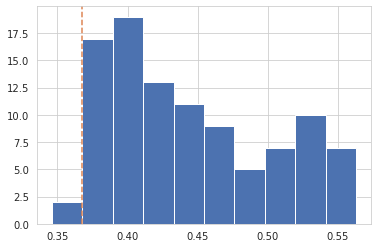

In [11]:
import seaborn as sns
palette = sns.color_palette('deep')
sns.set_style('whitegrid')
sns.set_palette(palette)

plt.hist(results, range = (min(float(exp(-1)), min(results)), max(results)))
plt.axvline(x=float(exp(-1)), color=palette[1], linestyle='dashed')
plt.show()